In [2]:
import pandas as pd
df = pd.read_csv('C:\\Users\\Pedro\\Desktop\\arquivos_exemplos\\TCC\\data_cleaning_new.csv', sep=';',  dtype={'ncm': str}, encoding='latin-1')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,descricao_item,ncm
0,BETAISTINA DICLOR MG CPS GEN Dicloridrato d...,30049069
1,BROMOPRIDA MG CPS GEN BROMOPRIDA,30049045
2,"DESLORATADINA ,MG ML XPE VD 6ML GEN DESLORAT...",30049069
3,ACETILCISTEINA 600MG G ENV G GEN ACETILCIST...,30049059
4,SANDALIA NEW AMAZONAS RETO CAVALERA INV 18 FEM...,64022000


In [3]:
df = df.sample(frac = 0.1, random_state=1)

In [4]:
df = df[pd.notnull(df['descricao_item'])]

In [5]:
df["ncm"] = df["ncm"].astype(str)
for i in range(len(df)):
  if len(df["ncm"].iloc[i]) < 8:
    df["ncm"].iloc[i] = "0"+ df["ncm"].iloc[i]
df['ncm'] = df['ncm'].astype(str).str[:2]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34325 entries, 20467 to 311962
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   descricao_item  34325 non-null  object
 1   ncm             34325 non-null  object
dtypes: object(2)
memory usage: 804.5+ KB


In [7]:
df.columns

Index(['descricao_item', 'ncm'], dtype='object')

In [8]:
df['category_id'] = df['ncm'].factorize()[0]
from io import StringIO
category_id_df = df[['ncm', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'ncm']].values)

In [9]:
df.head()

,descricao_item,ncm,category_id
20467,XADREZ ESCOLAR TABULEIRO MADEIRA PCS PLASTICA,95,0
263248,SAP FEMININO TRANCA GASPEA VEGETAL SEDA SKIN...,64,1
34065,ANEL BACKUP 101 75 X 107 75 X 1 27 G32176D,40,2
175826,LAMINA PARA DISPLAY RED BULL,49,3
113343,CONJ REGATA MALHA BERMUDA MICROFIBRA 06,62,4


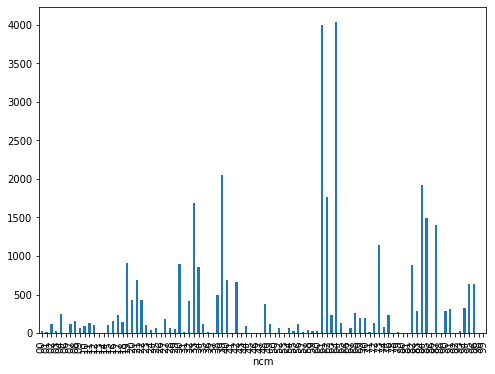

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('ncm').descricao_item.count().plot.bar(ylim=0)
plt.show()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.descricao_item).toarray()
labels = df.category_id
features.shape

(34325, 9004)

In [12]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# '00':
  . Most correlated unigrams:
       . 06mm
       . othil
  . Most correlated bigrams:
       . queijo mussarela
       . power tactel
# '01':
  . Most correlated unigrams:
       . bovino
       . boi
  . Most correlated bigrams:
       . cor tam
       . vestido curto
# '02':
  . Most correlated unigrams:
       . asa
       . cong
  . Most correlated bigrams:
       . da asa
       . frango cong
# '03':
  . Most correlated unigrams:
       . peixe
       . camarao
  . Most correlated bigrams:
       . linha pesca
       . chave luz
# '04':
  . Most correlated unigrams:
       . piracanjuba
       . iog
  . Most correlated bigrams:
       . bebida lactea
       . creme leite
# '06':
  . Most correlated unigrams:
       . cravo
       . india
  . Most correlated bigrams:
       . vestido curto
       . da india
# '07':
  . Most correlated unigrams:
       . carioca
       . feijao
  . Most correlated bigrams:
       . verde kg
       . feijao carioca
# '08':
  . Most correlat

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['descricao_item'], df['ncm'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\Pedro\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Pedro\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Pedro\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Pedro\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_

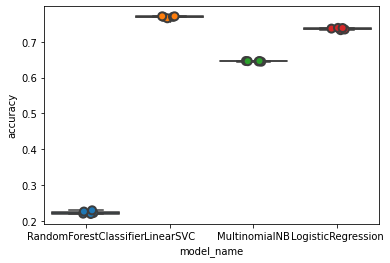

In [15]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.769381
LogisticRegression        0.736140
MultinomialNB             0.645594
RandomForestClassifier    0.223423
Name: accuracy, dtype: float64

In [17]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

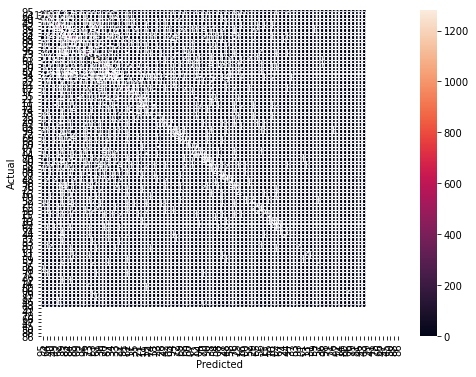

In [19]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.ncm.values, yticklabels=category_id_df.ncm.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['ncm', 'descricao_item']])
      print('')

'39' predicted as '95' : 9 examples.


,ncm,descricao_item
227022,39,PLASTCOVER 45XM M BABY ZOO
118908,39,COPO TERMICO POP GLITTER - LILICA FUN COLORS
63070,39,BRINQ IMP WELLMIX ROBO HERO ANIMAL
333154,39,MINI MARMITA FROZEN
35089,39,ANZOL N 08 C
190835,39,LUVINHA MORDEDOR URSO - AZUL
244529,39,ROLO ANTIRESPINGO 15CM REF ECON MESTRE
228061,39,PET MORDEDOR BOLA DE FUTEBOL
120287,39,COPO PLASUT C CAN 500ML R BATMAN


IndexError: index 85 is out of bounds for axis 0 with size 85

In [ ]:
model.fit(features, labels)

In [ ]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [ ]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))